In [1]:
import numpy as np
import scipy
import librosa
import madmom
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (FilteredSpectrogramProcessor,
                                      LogarithmicSpectrogramProcessor,
                                      SpectrogramDifferenceProcessor)
from madmom.features.onsets import OnsetPeakPickingProcessor
from madmom.evaluation.onsets import OnsetEvaluation, OnsetMeanEvaluation, OnsetSumEvaluation
from madmom.processors import SequentialProcessor
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import seaborn as sns
import re
import os

In [2]:
# %matplotlib notebook
%matplotlib inline
sns.set_theme(context='paper', font="Times New Roman", font_scale=.9)
colors = sns.color_palette("Blues", as_cmap=True)

In [3]:
# Feature extraction parameters
sr = 44100               # Sampling rate
fs = 2048                # Frame size
fps = 200                # Frames per second
window = np.hanning      # Hann-Window for STFT
num_bands = 24           # Number of bands per octave
f_min = 27.5             # Minimum frequency
f_max = 16000            # Maximum frequency
diff_max_bins = 3        # Number of bins used for maximum filter

# Peak picking and evaluation parameters
threshold = 0.6     # Threshold for peak-picking
pre_max = 0.03      # Use pre_max seconds past information for moving maximum
post_max = 0.03     # Use post_max seconds future information for moving maximum
pre_avg = 0.1       # Use pre_avg seconds past information for moving average
post_avg = 0.07     # Use post_avg seconds future information for moving average
eval_window = 0.05  # Time window around a reference onset
combine = 0.03      # Only report one onset within combine seconds
delay = 0           # Report the detected onsets delay seconds delayed


In [4]:
# Instantiate Processors with above parameters
signal_proc = SignalProcessor(sample_rate=sr, num_channels=1, norm=True)
frames_proc = FramedSignalProcessor(frame_size=fs, fps=fps)
stft_proc = ShortTimeFourierTransformProcessor(window=window)
fil_spec_proc = FilteredSpectrogramProcessor(num_bands=num_bands, fmin=f_min, fmax=f_max, norm_filters=False)
logfil_spec_proc = LogarithmicSpectrogramProcessor()
specDiffProc = SpectrogramDifferenceProcessor(diff_max_bins=diff_max_bins, positive_diffs=True)
peak_proc = OnsetPeakPickingProcessor(threshold=threshold,
                                      pre_max=pre_max,
                                      post_max=post_max,
                                      pre_avg=pre_avg,
                                      post_avg=post_avg,
                                      combine=combine,
                                      delay=delay,
                                      fps=fps)

preprocessor = SequentialProcessor([signal_proc, frames_proc, stft_proc, fil_spec_proc, logfil_spec_proc])


In [5]:
# File parameters
title = 'ah_development_guitar_2684_TexasMusicForge_Dandelion_pt1.flac'
audiofile = 'C:/Users/Steiner/Documents/Python/onset_detection/data/audio/' + title
annotationsfile = 'C:/Users/Steiner/Documents/Python/onset_detection/data/annotations/onsets/' + re.sub('\.flac$', '.onsets', title)
annotations = madmom.io.load_events(annotationsfile)

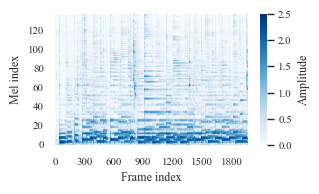

In [7]:
# Load and normalize audio file
signal, sr = librosa.load(audiofile, sr=sr, mono=True)

# Calculate preprocessed spectrogram
log_filtered_spec = preprocessor.process(signal)

# Plot preprocessed spectrogram
fig, axs = plt.subplots(figsize=(3.25, 2))
#fig, axs = plt.subplots()

sns.heatmap(data=log_filtered_spec.T, ax=axs, cmap=colors,
            cbar_kws={'label': 'Amplitude'}, vmin=0., vmax=2.5,
            xticklabels=300, yticklabels=20, rasterized=True)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
#axs.set_ylabel("Logarithmic Filterbank Output")
#axs.set_ylabel("Frequenz-Bins")
axs.set_ylabel("Mel index")
#axs.set_ylabel("Frequenz-Bins")

axs.set_yticklabels(axs.get_yticklabels(), rotation=0)

#axs.set_title(title)
plt.savefig("spectrogram.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()

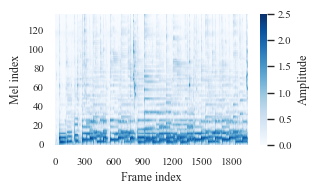

In [8]:
# Filter setup
img = log_filtered_spec.astype(np.float32)
fil1 = np.array([1.0, 0, -1.0], dtype=np.float32)  # Differenzfilter (1. Ableitung) auf Zeitachse
fil2 = np.array([1/3, 1/3, 1/3], dtype=np.float32) # Mittelwertfilter auf Frequenzachse
deriv = scipy.signal.sepfir2d(img, fil2, [1])
#deriv_hwr = np.maximum(deriv, 0)
# Plot filtered signal
fig, axs = plt.subplots(figsize=(3.25, 2))
#fig, axs = plt.subplots()

sns.heatmap(data=deriv.T, ax=axs, cmap=colors,
            cbar_kws={'label': 'Amplitude'}, vmin=0., vmax=2.5,
            xticklabels=300, yticklabels=20, rasterized=True)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
#axs.set_ylabel("Logarithmic Filterbank Output")
#axs.set_ylabel("Frequenz-Bins")
axs.set_ylabel("Mel index")
axs.set_yticklabels(axs.get_yticklabels(), rotation=0)
#axs.set_title(title)
#axs.eventplot(positions=annotations * 200, lineoffsets=70, linelengths=140)
plt.savefig("spektrogram_geglaettet.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()

In [ ]:
result = scipy.signal.sepfir2d(deriv, [1], fil1)
result_hwr = np.maximum(result, 0)
# Plot filtered signal
fig, axs = plt.subplots(figsize=(3.25, 2))
#fig, axs = plt.subplots()

sns.heatmap(data=result.T, ax=axs, cmap=colors,
            cbar_kws={'label': 'Amplitude'},
            xticklabels=300, yticklabels=20, rasterized=True)
axs.invert_yaxis()
axs.set_xlabel("Frame index")
#axs.set_ylabel("Logarithmic Filterbank Output")
#axs.set_ylabel("Frequenz-Bins")
axs.set_ylabel("Mel index")
#axs.set_ylabel("f / bins")
axs.set_yticklabels(axs.get_yticklabels(), rotation=0)

#axs.set_title(title)
#axs.eventplot(positions=annotations * 200, lineoffsets=70, linelengths=140)
plt.savefig("differenzspektrogramm.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()

In [ ]:
# Filter setup
deriv_hwr = np.maximum(deriv, 0)

# Plot filtered signal
fig, axs = plt.subplots()
sns.heatmap(data=deriv_hwr.T, ax=axs, cbar_kws={'label': 'Amplitude'})
axs.invert_yaxis()
axs.set_xlabel("Frame index")
axs.set_ylabel("Logarithmic Filterbank Output")
axs.set_title(title)
#axs.eventplot(positions=annotations * 200, lineoffsets=70, linelengths=140)
plt.tight_layout()
#plt.savefig("output/N3.png", bbox_inches="tight")

In [ ]:
# Calculate ODF by summing up the differences
odf = result_hwr.sum(axis=1)

# Plot ODF
#fig, axs = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots()
#axs.eventplot(positions=annotations * 200, lineoffsets=25, linelengths=50, color='#000000')
sns.lineplot(data=odf, ax=axs)
#circle1 = plt.Circle((225, 20), 8, color='r', fill=False, linewidth=1.5)
#circle2 = plt.Circle((293, 10), 8, color='r', fill=False, linewidth=1.5)
#circle3 = plt.Circle((800, 16), 8, color='r', fill=False, linewidth=1.5)

axs.set_xlabel("Frame index")
axs.set_ylabel("ODF")
#axs.add_patch(circle1)
#axs.add_patch(circle2)
#axs.add_patch(circle3)
axs.set_aspect(5)
plt.xlim([200, 1000])
plt.ylim([0, 50])
#axs.set_title(title)

#plt.savefig("Verteidigung_ODF_Beispiel.png", dpi=300, bbox_inches="tight")
#plt.tight_layout()


In [ ]:
f"report_{0}_{1}.log"

In [ ]:
# PeakPicking

proc = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=threshold,
                                                        pre_max=pre_max,
                                                        post_max=post_max,
                                                        pre_avg=pre_avg,
                                                        post_avg=post_avg, 
                                                        combine=combine, 
                                                        delay=delay,
                                                        fps=fps)

onsets_sf = proc(odf)

In [ ]:
# Evaluation
evl = madmom.evaluation.onsets.OnsetEvaluation(detections=onsets_sf,
                                               annotations=annotations,
                                               window=0.05,
                                               combine=0.03,
                                               delay=0)
print(evl)